In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
import multiprocessing
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", level=logging.INFO)

cores = multiprocessing.cpu_count() # Count the number of cores in a computer
print(cores)

8


In [62]:
def ground_truth_loader(ground_truth_file):
    # Read data from the text file
    with open(ground_truth_file, 'r') as file:
        data = file.read()

    # Convert the data to a list of tuples representing node labels
    node_labels = [tuple(map(int, line.split())) for line in data.split('\n') if line.strip()]

    # Create a dictionary to store labels for each node
    labels_dict = {}
    for node, label in node_labels:
        labels_dict[node] = label

    # Assuming the nodes are consecutive starting from 0 to determine the number of nodes
    num_nodes = max(labels_dict.keys()) + 1

    # Generate the list of ground truth labels
    ground_truth_labels = [labels_dict[node] if node in labels_dict else None for node in range(num_nodes)]

    print("Ground Truth Labels:")
    print(ground_truth_labels)
    return ground_truth_labels

In [63]:
def connectivity_loader(file_name):
    # Read data from the text file
    with open(file_name, 'r') as file:
        data = file.read()

    # Convert the data to a list of tuples representing edges
    edges = [tuple(map(int, line.split())) for line in data.split('\n') if line.strip()]

    # Find the maximum node ID to determine the size of the adjacency matrix
    max_node = max(max(edge) for edge in edges) + 1

    # Initialize an empty adjacency matrix
    adj_matrix = np.zeros((max_node, max_node), dtype=int)

    # Fill the adjacency matrix based on the edges
    for edge in edges:
        u, v = edge
        adj_matrix[u][v] = 1  # For undirected graph, set both adjacencies
        adj_matrix[v][u] = 1

    print("Adjacency Matrix:")
    print(adj_matrix[:10, :10])
    return adj_matrix

In [64]:
# Define the model architecture
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super(SkipGram, self).__init__()  # Call the parent class constructor
        self.embeddings = nn.Embedding(vocab_size, embed_size)      # input -> hidden
        self.linear1 = nn.Linear(embed_size, vocab_size)            # hidden -> output

    def forward(self, x):
        embeds = self.embeddings(x)
        out = self.linear1(embeds)
        probs = nn.functional.log_softmax(out, dim=1)
        return probs

In [65]:
class DeepWalk():
        def __init__(
                        self, 
                        graph : "list[list[int]]", 
                        window_size : int, 
                        embedding_size : int, 
                        walks_per_vertex : int, 
                        walk_length : int
                ) -> None:
                """
                Initialize the DeepWalk model. This directly from the paper https://arxiv.org/pdf/1403.6652.pdf.

                Parameters
                ----------
                graph : list[list[int]]
                        The adjacency list to be embedded. This is a list of lists, where each list is a vertex and its neighbors.
                window_size : int
                        The window size for the skipgram model.
                embedding_size : int
                        The size of the embedding. The final output matrix will be of size |V| x embedding_size.
                walks_per_vertex : int
                        The number of walks to perform per vertex.
                walk_length : int
                        The length of each walk.

                Methods
                -------
                generate_n_walks()
                        Generate n walks from the graph.
                train()
                        Train the model.
                update()
                        Feed model new walks.
                get_embeddings()
                        Return the embeddings.
                """

                # DeepWalk parameters
                self.g = graph
                self.w = window_size
                self.d = embedding_size
                self.gamma = walks_per_vertex
                self.epochs = self.gamma
                self.t = walk_length
                self.n = len(graph)

        def unbiased_random_walk(
                self,
                adj_mat : 'list[list[int]]', 
                walk_len : 'int', 
                start_node : 'int'
        ) -> np.array:
                """
                Returns a random walk of length walk_len from start_node in the graph.

                Parameters
                ----------
                adj_mat : list[list[int]]
                        Adjacency matrix of the graph.
                walk_len : int
                        Length of the random walk.
                start_node : int
                        Starting node of the random walk.

                Returns
                -------
                np.array
                        List of nodes in the random walk.        
                """
                # Array to store the walk
                walk = [start_node]

                # Make an adjacency matrix to easily 
                # sample the neighbors of a node.
                adj_list = []
                for i in range(len(adj_mat)):
                        # This line was autocompleted by GH Copilot
                        adj_list.append(np.where(adj_mat[i] > 0)[0])

                # Keep walking for walk_len epochs
                for epochs in range(walk_len):
                        # Randomly pick a node from the adj_list[walk[-1]] 
                        # and append it to the walk
                        walk.append(np.random.choice(adj_list[walk[-1]]))

                return np.array(walk)

        def generate_n_walks(self, num_iters : int) -> 'list[list[str]]':
                """
                Generate a list of num_iters random walks. These will be used to train the model

                Parameters
                ----------
                num_iters : int
                        Number of walks to generate.

                Returns
                -------
                np.ndarray
                        List of random walks.
                """

                # List to store the walks
                walks = []

                # For each vertex in the graph
                for vertex in range(self.n):
                        # Generate gamma walks of length t
                        for _ in range(self.gamma):
                                walks.append(self.unbiased_random_walk(self.g, self.t, vertex))

                walks = [[str(node) for node in walk] for walk in walks]

                return walks

        def train(self, epochs : int, lr : float) -> None:
                """
                Train the model.

                Parameters
                ----------
                epochs : int
                        Number of epochs to train the model for.
                lr : float
                        Learning rate for the optimizer.                
                """

                # Generate many walks
                walks = self.generate_n_walks(self.gamma)

                # Initialize the model
                self.model = Word2Vec(
                        walks,
                        hs=1,
                        sg=1,
                        alpha=0.05,
                        epochs=self.epochs, 
                        vector_size=self.d,        # embedding dimension
                        window=self.w,             # context window size
                        min_count=0,
                        workers=cores-2
                )

        def get_embeddings(self) -> np.ndarray:
                """
                Return the embeddings.

                Returns
                -------
                np.ndarray
                        Embeddings.
                """
                return [self.model.wv[str(n)] for n in range(self.n)]
        
        def plot_embeddings(self, num_dimensions : int, gt_labels : 'list[str]') -> None:
                """
                Plot the embeddings.

                Parameters
                ----------
                num_dimensions : int
                        Number of dimensions to plot.
                gt_labels : list[str]
                        List of ground truth labels.
                """
                embeddings = np.array(self.get_embeddings())

                # dimensionality reduction to 2 dimensions using t-SNE for visualization
                embeddings = TSNE(n_components=2).fit_transform(embeddings)

                # Convert gt into numbers
                gt_labels = np.array(gt_labels)

                # Iterate over all labels and assign them an integer
                for i, label in enumerate(np.unique(gt_labels)):
                        gt_labels[gt_labels == label] = i
                gt_labels = gt_labels.astype(int)

                # plot the embeddings
                plt.figure(figsize=(6,6))
                plt.scatter(embeddings[:,0], embeddings[:,1], c=gt_labels)

                # Plot node numbers
                for i in range(len(embeddings)):
                        plt.annotate(i, (embeddings[i,0], embeddings[i,1]))
                        
                plt.show()

Adjacency Matrix:
[[1 1 0 0 0 1 1 0 0 0]
 [1 1 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 0 0 0]
 [0 0 1 1 1 0 1 0 0 0]
 [0 0 1 1 1 0 1 0 0 0]
 [1 0 1 0 0 1 1 1 0 0]
 [1 0 1 1 1 1 1 0 0 0]
 [0 0 0 0 0 1 0 1 1 0]
 [0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 1 1]]
Ground Truth Labels:
[1, 1, 21, 21, 21, 25, 25, 14, 14, 14, 9, 14, 14, 26, 4, 17, 34, 1, 1, 14, 9, 9, 9, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 5, 34, 14, 14, 17, 17, 10, 10, 36, 37, 5, 7, 4, 22, 22, 21, 21, 21, 21, 7, 7, 36, 21, 25, 4, 8, 15, 15, 15, 37, 37, 9, 1, 1, 10, 10, 3, 3, 3, 29, 15, 36, 36, 37, 1, 36, 34, 20, 20, 8, 15, 9, 4, 5, 4, 20, 16, 16, 16, 16, 16, 38, 7, 7, 34, 38, 36, 8, 27, 8, 8, 8, 10, 10, 13, 13, 6, 26, 10, 1, 36, 0, 13, 16, 16, 22, 6, 5, 4, 0, 28, 28, 4, 2, 13, 13, 21, 21, 17, 17, 14, 36, 8, 40, 35, 15, 23, 0, 0, 7, 10, 37, 27, 35, 35, 0, 0, 19, 19, 36, 14, 37, 24, 17, 13, 36, 4, 4, 13, 13, 10, 4, 38, 32, 32, 4, 1, 0, 0, 0, 7, 7, 4, 15, 16, 40, 15, 15, 15, 15, 0, 21, 21, 21, 21, 5, 4, 4

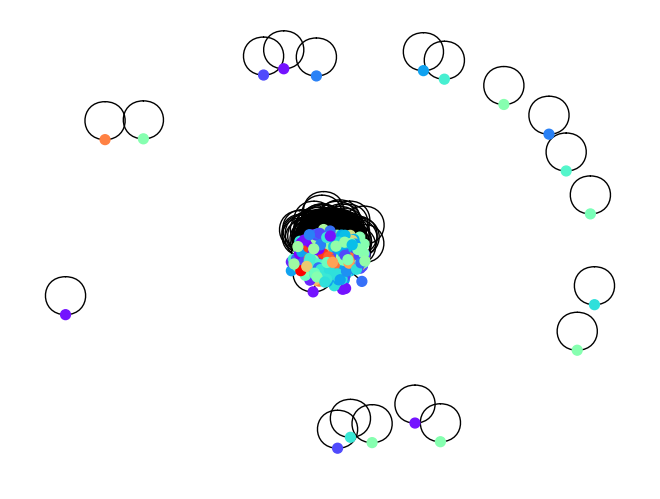

In [66]:
# load the adjacency matrix
adjmat = connectivity_loader('connectivity.txt')

# load the ground truth data
gt_labels = ground_truth_loader('labels.txt')

# visualise the graph -> using networkx
G = nx.from_numpy_array(adjmat)
nx.draw(G, pos = nx.spring_layout(G),node_color=gt_labels, cmap=plt.cm.rainbow,node_size=50)

In [67]:
ground_truth_loader('labels.txt')

Ground Truth Labels:
[1, 1, 21, 21, 21, 25, 25, 14, 14, 14, 9, 14, 14, 26, 4, 17, 34, 1, 1, 14, 9, 9, 9, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 5, 34, 14, 14, 17, 17, 10, 10, 36, 37, 5, 7, 4, 22, 22, 21, 21, 21, 21, 7, 7, 36, 21, 25, 4, 8, 15, 15, 15, 37, 37, 9, 1, 1, 10, 10, 3, 3, 3, 29, 15, 36, 36, 37, 1, 36, 34, 20, 20, 8, 15, 9, 4, 5, 4, 20, 16, 16, 16, 16, 16, 38, 7, 7, 34, 38, 36, 8, 27, 8, 8, 8, 10, 10, 13, 13, 6, 26, 10, 1, 36, 0, 13, 16, 16, 22, 6, 5, 4, 0, 28, 28, 4, 2, 13, 13, 21, 21, 17, 17, 14, 36, 8, 40, 35, 15, 23, 0, 0, 7, 10, 37, 27, 35, 35, 0, 0, 19, 19, 36, 14, 37, 24, 17, 13, 36, 4, 4, 13, 13, 10, 4, 38, 32, 32, 4, 1, 0, 0, 0, 7, 7, 4, 15, 16, 40, 15, 15, 15, 15, 0, 21, 21, 21, 21, 5, 4, 4, 4, 4, 4, 4, 4, 5, 5, 4, 4, 22, 19, 19, 22, 34, 14, 0, 1, 17, 37, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 10, 23, 0, 4, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 10, 14, 14, 1, 14, 7, 13, 20, 31, 40, 6, 4, 0, 8, 9, 9, 10, 0, 10, 14, 14, 14, 14, 39, 

[1,
 1,
 21,
 21,
 21,
 25,
 25,
 14,
 14,
 14,
 9,
 14,
 14,
 26,
 4,
 17,
 34,
 1,
 1,
 14,
 9,
 9,
 9,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 5,
 34,
 14,
 14,
 17,
 17,
 10,
 10,
 36,
 37,
 5,
 7,
 4,
 22,
 22,
 21,
 21,
 21,
 21,
 7,
 7,
 36,
 21,
 25,
 4,
 8,
 15,
 15,
 15,
 37,
 37,
 9,
 1,
 1,
 10,
 10,
 3,
 3,
 3,
 29,
 15,
 36,
 36,
 37,
 1,
 36,
 34,
 20,
 20,
 8,
 15,
 9,
 4,
 5,
 4,
 20,
 16,
 16,
 16,
 16,
 16,
 38,
 7,
 7,
 34,
 38,
 36,
 8,
 27,
 8,
 8,
 8,
 10,
 10,
 13,
 13,
 6,
 26,
 10,
 1,
 36,
 0,
 13,
 16,
 16,
 22,
 6,
 5,
 4,
 0,
 28,
 28,
 4,
 2,
 13,
 13,
 21,
 21,
 17,
 17,
 14,
 36,
 8,
 40,
 35,
 15,
 23,
 0,
 0,
 7,
 10,
 37,
 27,
 35,
 35,
 0,
 0,
 19,
 19,
 36,
 14,
 37,
 24,
 17,
 13,
 36,
 4,
 4,
 13,
 13,
 10,
 4,
 38,
 32,
 32,
 4,
 1,
 0,
 0,
 0,
 7,
 7,
 4,
 15,
 16,
 40,
 15,
 15,
 15,
 15,
 0,
 21,
 21,
 21,
 21,
 5,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 4,
 4,
 22,
 19,
 19,
 22,
 34,
 14,
 0,


In [68]:
# adjacenecy matrix, window size, embedding size, walks per vertex, walk length
dw = DeepWalk(adjmat, 10, 128, 10, 80)

In [69]:
dw.train(1, 0.05)

KeyboardInterrupt: 